In [1]:
using PyCall

using DrWatson
quickactivate(@__DIR__)

include(projectdir("scripts", "notebooks_netsense_funs.jl"))

using CairoMakie

In [2]:
fname = datadir("exp_pro", "NetSense_network.pkl")
file = load_pickle(fname)

Dict{Any, Any} with 6 entries:
  5 => PyObject <networkx.classes.graph.Graph object at 0x7f5048bc74f0>
  4 => PyObject <networkx.classes.graph.Graph object at 0x7f5048c0c8b0>
  6 => PyObject <networkx.classes.graph.Graph object at 0x7f5048b897f0>
  2 => PyObject <networkx.classes.graph.Graph object at 0x7f5048c85fd0>
  3 => PyObject <networkx.classes.graph.Graph object at 0x7f5048c4fc10>
  1 => PyObject <networkx.classes.graph.Graph object at 0x7f507398d8b0>

In [3]:
As = [get_adjacency_matrix(file[i]) for i in 1:6]
A1 = get_adjacency_matrix(file[1])
A2 = As[2]
A1

98×98 Matrix{Int64}:
  0  11    0    4   2   0   0   0   0  …  0  0  0   0   0  0   0  0  0  0  0
 11   0   61    8   0   0   0   0   0     0  0  0   0   0  0   0  0  0  0  0
  0  61    0  193  19   0   0   0   0     0  0  0   0   0  0   0  0  0  0  0
  4   8  193    0   5   0   0   0   8     0  0  0   0   0  0   0  0  0  0  0
  2   0   19    5   0   0   0   7   0     0  0  0   0   0  0   0  1  0  0  0
  0   0    0    0   0   0  18  36  49  …  0  0  0   0   0  0   0  0  0  0  0
  0   0    0    0   0  18   0   0   0     0  0  0   0   0  0   0  2  0  0  0
  0   0    0    0   7  36   0   0  81     0  0  0   0   0  0   0  0  0  0  0
  0   0    0    8   0  49   0  81   0     0  0  0   0   0  0   0  0  0  0  0
  0   0    0    0   0   0   0   0   0     0  0  0   0   0  0   0  0  0  0  0
  ⋮                     ⋮              ⋱            ⋮                ⋮     
  0   0    0    0   0   0   0   0   0     0  0  0   0   0  0   0  0  0  0  0
  0   0    0    0   0   0   0   0   0  …  0  0  0   0  8

In [4]:
nodes = get_all_nodes(file)
Ws = create_series_adj_mat(file, nodes)
As = [sign.(W) for W in Ws]

all_triads = [get_triads2(As[i]) for i in 1:6];

In [5]:
# Let's check how many people are in triads

triad_nodes = sort(unique([node for triads in all_triads for triad in triads for node in triad]))
display(length(triad_nodes))

# There are only 60 nodes, so lets repeat above experiment with generating links only among these agents. 
# But first I need to count how many edges were added among those agents

As2 = [As[i][triad_nodes, triad_nodes] for i in 1:6]

60

6-element Vector{Matrix{Int64}}:
 [0 1 … 0 0; 1 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 1; … ; 0 0 … 0 0; 0 1 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]

## Let's count attribute changes now

In [6]:
#creating list of attributes
list_of_attributes = Set([k for n in file[1].nodes for k in keys(file[1].nodes[n+1])])

# creating possible attribute values
attribute_values = Dict((attribute, Set() ) for attribute in list_of_attributes)

for sem in 1:6
    for node in file[sem].nodes()
        for attribute in list_of_attributes
            push!(attribute_values[attribute], convert(Int, file[sem].nodes[node + 1][attribute]))
        end
    end
end

attribute_values

#To apply PCA or other analysis on all attributes (i.e. including ethnicity) 
#one would have to create an attribute for each race, that is is_1, is_2 etc. 
#Because this attribute is not ordered. 

Dict{String, Set{Any}} with 12 entries:
  "premaritalsex_" => Set([2, 3, 1])
  "ethnicity_1"    => Set([4, 2, 3, 1])
  "hometown_1"     => Set([2, 3, 1])
  "political_"     => Set([2, 3, 1])
  "abortion_"      => Set([2, 3, 1])
  "homosexual_"    => Set([2, 3, 1])
  "marijuana_"     => Set([2, 3, 1])
  "gender_1"       => Set([2, 1])
  "gaymarriage_"   => Set([2, 3, 1])
  "deathpen_"      => Set([2, 3, 1])
  "euthanasia_"    => Set([2, 3, 1])
  "age_1"          => Set([2, 1])

In [7]:
#creating table of attribute values
attributes = Dict((i, zeros(length(nodes), length(list_of_attributes))) for i in 1:6)
# for i in 1:6
#     attributes[i] = zeros(length(file[i].nodes), length(list_of_attributes))
# end

for sem in 1:6
    for (i, node) in enumerate(nodes)
        for (j, attribute) in enumerate(list_of_attributes)
            if node in file[sem].nodes()
                attributes[sem][i,j] = file[sem].nodes[node + 1][attribute]
            else
                attributes[sem][i,j] = NaN
            end
        end
    end
end
attributes

Dict{Int64, Matrix{Float64}} with 6 entries:
  5 => [3.0 3.0 … 2.0 1.0; 3.0 3.0 … 2.0 2.0; … ; NaN NaN … NaN NaN; 1.0 3.0 … …
  4 => [3.0 3.0 … 2.0 1.0; 3.0 3.0 … 2.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 3.0 … …
  6 => [NaN NaN … NaN NaN; 3.0 3.0 … 2.0 2.0; … ; NaN NaN … NaN NaN; NaN NaN … …
  2 => [NaN NaN … NaN NaN; 3.0 3.0 … 2.0 2.0; … ; NaN NaN … NaN NaN; NaN NaN … …
  3 => [3.0 3.0 … 2.0 1.0; 3.0 1.0 … 2.0 2.0; … ; NaN NaN … NaN NaN; NaN NaN … …
  1 => [3.0 3.0 … 2.0 1.0; 2.0 2.0 … 2.0 1.0; … ; NaN NaN … NaN NaN; NaN NaN … …

In [8]:

ord_list_of_attributes = setdiff(list_of_attributes, ["ethnicity_1", "gender_1", "hometown_1", "age_1"])
print(ord_list_of_attributes)

#creating table of attribute values
ord_attributes = Dict((i, zeros(length(nodes), length(ord_list_of_attributes))) for i in 1:6)

for sem in 1:6
    for (i, node) in enumerate(nodes)
        for (j, attribute) in enumerate(ord_list_of_attributes)
            if node in file[sem].nodes()
                ord_attributes[sem][i,j] = file[sem].nodes[node + 1][attribute]
            else
                ord_attributes[sem][i,j] = NaN
            end
        end
    end
end
# for sem in range(1,7):
#     for i, node in enumerate(data[sem].nodes()):
#         for j, attribute in enumerate(ord_list_of_attributes):
#             ord_attributes[sem][i,j] = data[sem].nodes[node][attribute]
ord_attributes

Set(["abortion_", "premaritalsex_", "homosexual_", "marijuana_", "euthanasia_", "gaymarriage_", "deathpen_", "political_"])

Dict{Int64, Matrix{Float64}} with 6 entries:
  5 => [3.0 3.0 … 3.0 1.0; 3.0 3.0 … 3.0 2.0; … ; NaN NaN … NaN NaN; 1.0 3.0 … …
  4 => [3.0 3.0 … 3.0 1.0; 3.0 3.0 … 1.0 1.0; … ; 1.0 1.0 … 3.0 1.0; 1.0 3.0 … …
  6 => [NaN NaN … NaN NaN; 3.0 3.0 … 3.0 2.0; … ; NaN NaN … NaN NaN; NaN NaN … …
  2 => [NaN NaN … NaN NaN; 3.0 3.0 … 1.0 2.0; … ; NaN NaN … NaN NaN; NaN NaN … …
  3 => [3.0 3.0 … 3.0 1.0; 3.0 1.0 … 1.0 2.0; … ; NaN NaN … NaN NaN; NaN NaN … …
  1 => [3.0 3.0 … 3.0 1.0; 2.0 2.0 … 2.0 1.0; … ; NaN NaN … NaN NaN; NaN NaN … …

## Let us calculate triad transitions including nans

In [9]:
ths = [0:0.01:1...]
bal_to_bals = []
ubal_to_bals = []
bal_to_bals2 = []
ubal_to_bals2 = []
bal_to_bals3 = []
ubal_to_bals3 = []
bal_to_ubals3 = []
ubal_to_ubals3 = []
bal_to_nots3 = []
ubal_to_nots3 = []

for th in ths
    res = get_triad_transitions(all_triads, th, ord_attributes; all_triads_list = [] )
    bal_to_bal = res[1][1,1] / sum(res[1][1,1:2])
    ubal_to_bal = res[1][2,1] / sum(res[1][2,1:2])
    bal_to_bal2 = res[3][1,1] / sum(res[3][1,1:2])
    ubal_to_bal2 = res[3][2,1] / sum(res[3][2,1:2])
    bal_to_bal3 = res[1][1,1] / sum(res[1][1,1:3])
    ubal_to_bal3 = res[1][2,1] / sum(res[1][2,1:3])
    bal_to_ubal3 = res[1][1,2] / sum(res[1][1,1:3])
    ubal_to_ubal3 = res[1][2,2] / sum(res[1][2,1:3])
    bal_to_not3 = res[1][1,3] / sum(res[1][1,1:3])
    ubal_to_not3 = res[1][2,3] / sum(res[1][2,1:3])
    
    push!(bal_to_bals, bal_to_bal)
    push!(ubal_to_bals, ubal_to_bal)
    push!(bal_to_bals2, bal_to_bal2)
    push!(ubal_to_bals2, ubal_to_bal2)
    push!(bal_to_bals3, bal_to_bal3)
    push!(ubal_to_bals3, ubal_to_bal3)
    push!(bal_to_ubals3, bal_to_ubal3)
    push!(ubal_to_ubals3, ubal_to_ubal3)
    push!(bal_to_nots3, bal_to_not3)
    push!(ubal_to_nots3, ubal_to_not3)
end

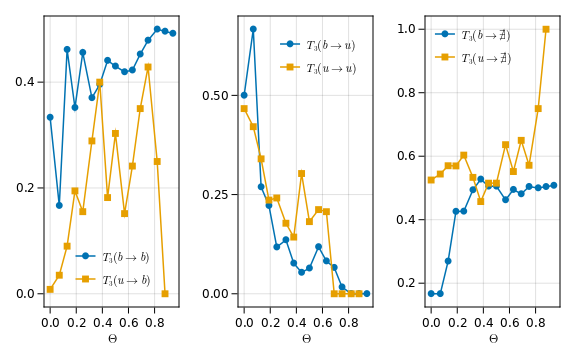

In [33]:
labeltype = "bu" # Options: "pm" or "bu"
points = 16

if labeltype == "pm" 
    label_b2b = "T(+→+)"
    label_u2b = "T(−→+)"
    label_b2u = "T(+→−)"
    label_u2u = "T(−→−)"
    label_b2n = "T(+→∄)"
    label_u2n = "T(−→∄)"
elseif labeltype == "bu"
    label_b2b = L"${T}_3(b→b)$"
    label_u2b = L"${T}_3(u→b)$"
    label_b2u = L"${T}_3(b→u)$"
    label_u2u = L"${T}_3(u→u)$"
    label_b2n = L"${T}_3(b\rightarrow ∄)$"
    label_u2n = L"${T}_3(u→∄)$"
else
    error("Wrong label type")
end

chosen_ths = [0:points-1...] ./ points
inds = [findfirst(ths .>= chosen_ths[i]) for i in 1:length(chosen_ths)]

colors = Makie.wong_colors()
markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

size_inches = (8, 5)
size_pt = 72 .* size_inches
fig = Figure(resolution = size_pt, fontsize = 12)

ga = fig[1, 1] = GridLayout()

axleft = Axis(ga[1, 1], xlabel = L"$\Theta$")
axcen = Axis(ga[1, 2], xlabel = L"$\Theta$")
axright = Axis(ga[1, 3], xlabel = L"$\Theta$")

scatterlines!(axleft, ths[inds], bal_to_bals3[inds] .+ 0, marker = markers[1], label = label_b2b)
scatterlines!(axleft, ths[inds], ubal_to_bals3[inds] .+ 0, marker = markers[2], label = label_u2b) 
scatterlines!(axcen, ths[inds], bal_to_ubals3[inds] .+ 0, marker = markers[1], label = label_b2u)
scatterlines!(axcen, ths[inds], ubal_to_ubals3[inds] .+ 0, marker = markers[2], label = label_u2u) 

scatterlines!(axright, ths[inds], bal_to_nots3[inds] .+ 0, marker = markers[1], label = label_b2n)
scatterlines!(axright, ths[inds], ubal_to_nots3[inds] .+ 0, marker = markers[2], label = label_u2n) 

# plot!(p1, legend = :outertopright)
# plot!(p1, legend = :outerbottom)
# plot!(p2, legend = false)
# plot!(p3, legend = false)
# title!(p2, "Including NaNs")
# plot(p1, p2, p3, layout = (1,3))

axislegend(axleft, position = :cb, framevisible = false)
axislegend(axcen, position = :rt, framevisible = false)
# axislegend(axright, position = :lt, framevisible = false, tellheight = false,
axislegend(axright, framevisible = false, tellheight = false,
tellwidth = false,
margin = (0, 0, 0, 0),
halign = :left, valign = :top)

safesave(
        projectdir("plots", "triad_nans_trans.pdf"),
        fig
    )

fig

In [40]:
cor_ths = ths[inds]
cor_bal_to_bals3 = bal_to_bals3[inds]
cor_ths = LinRange(0, 15. /16, 16)

16-element LinRange{Float64}:
 0.0,0.0625,0.125,0.1875,0.25,0.3125,…,0.625,0.6875,0.75,0.8125,0.875,0.9375

In [55]:
f = Figure()
Axis(f[1, 1])


xs = LinRange(0, 10, 20)
ys2 = 0.5 .* sin.(xs)

ys2 = 0.5 .* sin.(cor_ths)

scatterlines!(cor_ths, cor_bal_to_bals3)
# scatterlines!(cor_ths, cor_bal_to_bals3 .- 1, markercolor = :red)
# scatterlines!(xs, ys .- 2, markersize = LinRange(5, 30, 20))
# scatterlines!(xs, ys .- 3, marker = :cross, strokewidth = 0,
#     strokecolor = :red, markercolor = :orange)

f

ErrorException: `Makie.convert_arguments` for the plot type Lines{Tuple{LinRange{Float64}, Vector{Any}}} and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Float32}, ::Vector{Any}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://makie.juliaplots.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


In [58]:
cor_bal_to_bals3 .- 0

16-element Vector{Float64}:
 0.3333333333333333
 0.16666666666666666
 0.46153846153846156
 0.35185185185185186
 0.45588235294117646
 0.37037037037037035
 0.3956043956043956
 0.44086021505376344
 0.43010752688172044
 0.41935483870967744
 0.422680412371134
 0.4528301886792453
 0.4789915966386555
 0.5
 0.496
 0.49206349206349204

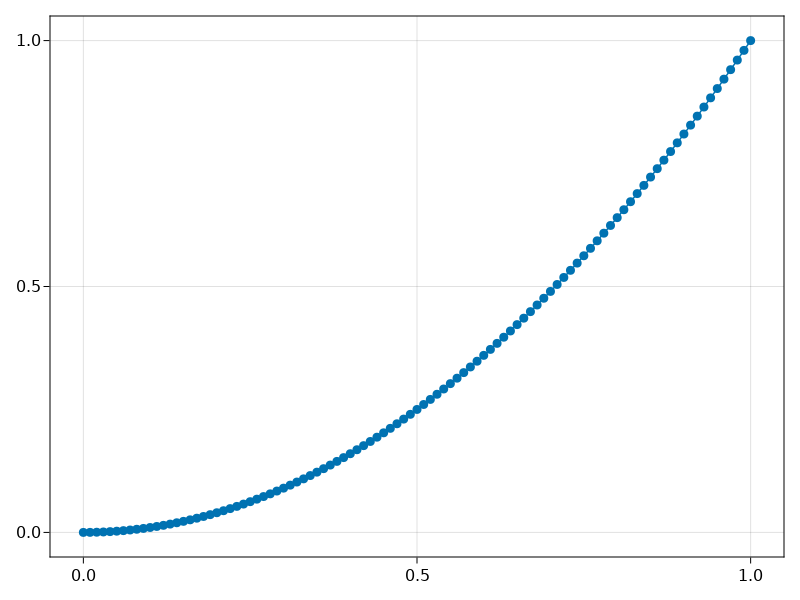

In [62]:
xs = [0:0.01:1...]
ys = []

for x in xs
    
    push!(ys, x^2)
end

f = Figure()
Axis(f[1, 1])

scatterlines!(xs, ys .+ 0)

f